In [8]:
import scanpy as sc
import pandas as pd
import anndata
import os
import sys
import seaborn as sns
import pdb

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

# from scripts.utils import *
from scripts.plotting import *

In [9]:
adata = '../talon/talon_adata.h5ad'
adata = sc.read(adata)

In [10]:
def plot_perc_n_exons(adata,
                      obs_col):
    n_exons = []
    n_reads = []
    cats = []
    for n in adata.var.n_exons.unique():
        for cat in adata.obs[obs_col].unique():
            
            # get valid entries
            cells = adata.obs.loc[adata.obs[obs_col]==cat].index
            tids = adata.var.loc[adata.var.n_exons==n].index
            
            # append to lists
            n_reads.append(adata[cells, tids].X.sum().sum())
            n_exons.append(n)
            cats.append(cat)
    
    # make df
    df = pd.DataFrame()
    df['n_exons'] = n_exons
    df['n_reads'] = n_reads
    df[obs_col] = cats
    
    temp = df[['n_reads', obs_col]].groupby(obs_col).sum().reset_index()
    temp.rename({'n_reads': 'n_total_reads'}, axis=1, inplace=True)
    df = df.merge(temp, how='left', on=obs_col)
                 
    
    df['perc'] = df.n_reads/df.n_total_reads
    
    ax = sns.catplot(df,
                    x='n_exons',
                    y='perc',
                    hue=obs_col,
                    kind='bar')
    ax.set(xlim=(-1,10), xlabel='# exons', ylabel='% reads')
    

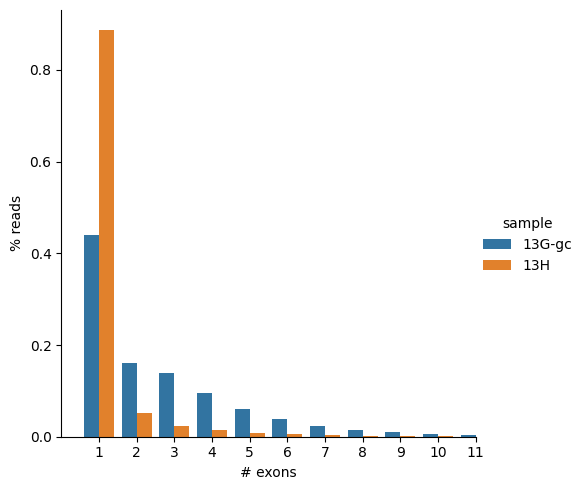

In [4]:
plot_perc_n_exons(adata,
                  'sample')

In [30]:
obs_col = 'sample'
obs_condition = '13H'

def add_perc(ax, data, feature):
    total = data[feature].sum()
    ylim = ax.get_ylim()[1]
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.45
        y = p.get_y() + p.get_height() + ylim*0.00625
        ax.annotate(percentage, (x, y), size = 10)

def plot_read_novelty(adata, obs_col=None, obs_condition=None,
                      ylim=None, title=None, fname=None):
    sns.set_context("paper", font_scale=1.2)
    
    c_dict, order = get_talon_nov_colors()
    novs = []
    n_reads = []
    for n in adata.var.transcript_novelty.unique():
        tids = adata.var.loc[adata.var.transcript_novelty==n].index
        if obs_col:
            cells = adata.obs.loc[adata.obs[obs_col] == obs_condition].index
        else:
            cells = adata.obs.index
        n_reads.append(adata[cells, tids].X.sum().sum())
        novs.append(n)

    df = pd.DataFrame()
    df['transcript_novelty'] = novs
    df['n_reads'] = n_reads

    # actual plotting
    g = sns.catplot(data=df, x='transcript_novelty',
                y='n_reads', kind='bar',
                palette=c_dict, order=order)
    [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
    g.set_ylabels('Reads')
    g.set_xlabels('Transcript novelty')

    # add percentage labels
    ax = g.axes[0,0]
    add_perc(ax, df, 'n_reads')

    if ylim:
        g.set(ylim=(0,ylim))

    # add title
    if not title:
        g.fig.suptitle('Reads per novelty category')
    else:
        g.fig.suptitle('{} reads per novelty category'.format(title))

    # save figure
    if fname:
        g.savefig(fname, dpi=300)

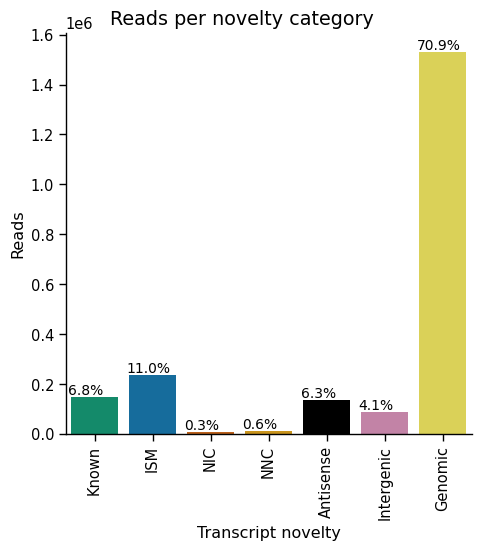

In [31]:
plot_read_novelty(adata, 'sample', '13H')

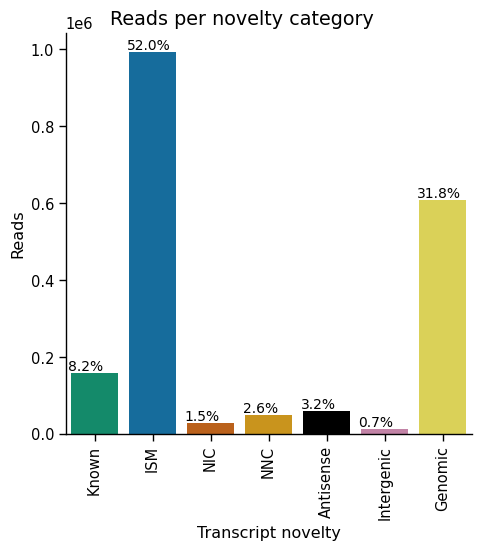

In [33]:
plot_read_novelty(adata, 'sample', '13G-gc')

In [8]:

n_exons = []
n_reads = []
for n in adata.var.n_exons.unique():
    for lib
    tids = adata.var.loc[adata.var.n_exons==n].index
    n_reads.append(adata[:, tids].X.sum().sum())
    n_exons.append(n)
df = pd.DataFrame()
df['n_exons'] = n_exons
df['n_reads'] = n_reads
    

In [9]:
df.head()

,n_exons,n_reads
0,2,420561.0
1,1,2752443.0
2,5,134646.0
3,4,212652.0
4,9,21740.0


In [2]:
# read read_annot file
filt_bcs = '../talon/hippocampus_filt_bcs.txt'
df = pd.read_csv('../talon/hippocampus_talon_read_annot.tsv', sep='\t')
df = get_transcript_exp(df,
                  nov=['Known', 'NIC', 'NNC'],
                  filt_sc_novel=True,
                  filt_bcs=filt_bcs)

# construct adata with illumina and sample metadata
samp_df = get_sample_metadata('hippocampus')
sr_df = get_illumina_metadata('hippocampus', include_raw=False)

adata = make_adata(df, samp_df, sr_df, how='transcript', verbose=True)

adata.write('transcript_raw.h5ad')

Found 96 unique bc3s
Found 95 unique bc2s
Found 48 unique bc1s


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'bc' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'bc3_long' as categorical
/U

In [3]:
# remove sr statistics from ONT data first -- we don't actually 
# have matching sr statistics fr those
adata.obs.loc[adata.obs.experiment == 'ont_b', ['sr_umi_count', 'sr_gene_count']] = np.nan
adata.write('transcript_raw.h5ad')

## Processing

In [4]:
adata = sc.read('transcript_raw.h5ad')

In [5]:
# add gene-level clustering, UMAP coords
gene_df = pd.read_csv('gene_metadata.tsv', sep='\t')
gene_df.head()
adata.obs = adata.obs.merge(gene_df, how='left', left_index=True, right_on='bc_index')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0.0, 1.0, 2.0, 3.0, 4.0]

    Inferred to be: floating

  value_idx = self._prep_dim_index(value.index, attr)


In [6]:
adata.obs.set_index('bc_index', inplace=True)

In [7]:
adata.obsm['X_umap'] = np.asarray([[x,y] for x,y in zip(adata.obs['umap_x'].tolist(), adata.obs['umap_y'].tolist())])

In [8]:
print(len(adata.var.index))
# adata.var.head()

28880


In [9]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=0)

In [10]:
# filter out the cells that didn't pass anything in the gene-level analysis
print(len(adata.obs.index))
adata = adata[~adata.obs.lr_celltype.isnull(), :]
print(len(adata.obs.index))

6049
5877


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'lr_sub_celltype' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), in

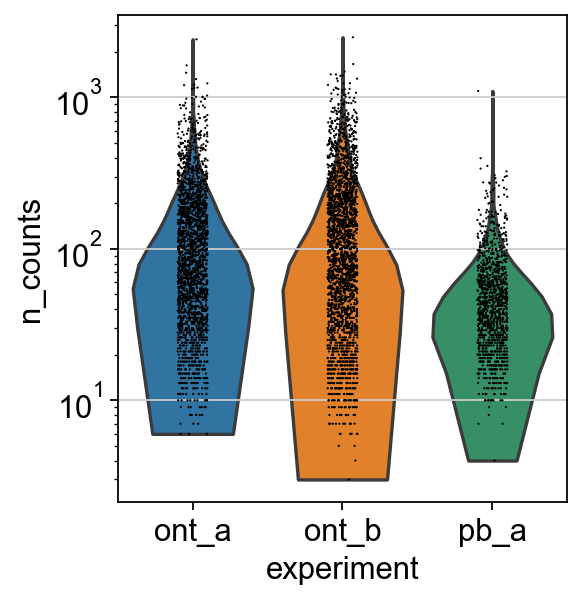

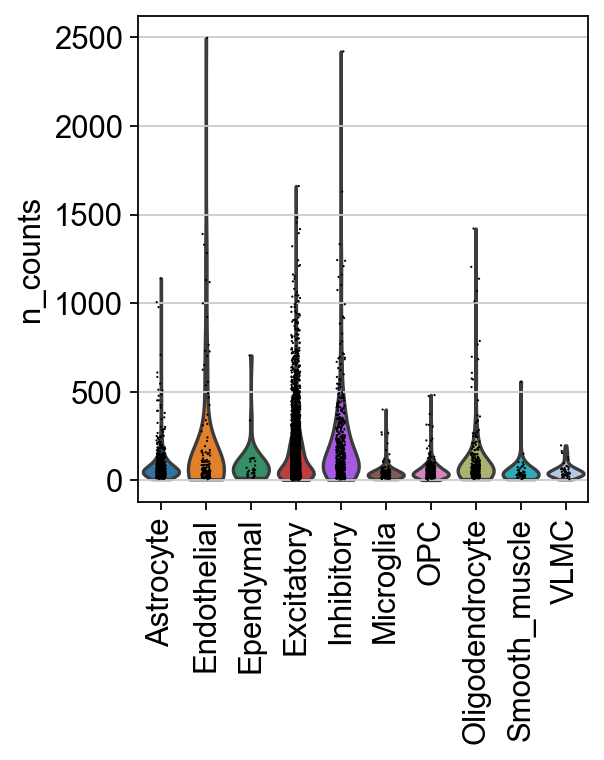

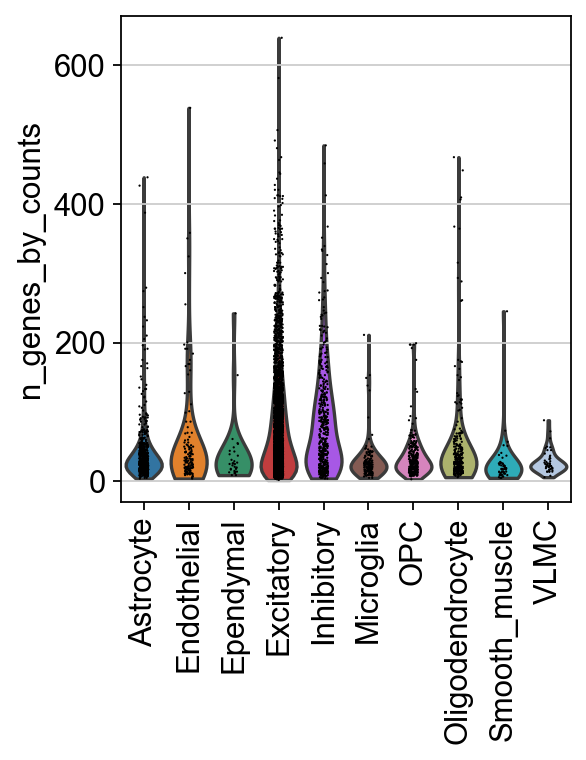

In [11]:
sc.settings.set_figure_params(frameon=False)
sc.settings.figdir = 'figures'
sc.pl.violin(adata, 'n_counts', groupby='experiment', log=True,
             save='_counts_per_cell.png')
sc.pl.violin(adata, 'n_counts', groupby='lr_celltype',
             rotation=90,
             save='_lr_celltype_counts_per_cell.png')
sc.pl.violin(adata, 'n_genes_by_counts', groupby='lr_celltype',
             rotation=90,
             save='_lr_celltype_genes_per_cell.png')

In [12]:
# how many reads do we have total? 
adata.var.total_counts.sum()

904014.0

In [13]:
# how many reads do we have per isoform and per gene?
adata.var.groupby('total_counts').count()

,annot_transcript_id,annot_gene_id,annot_gene_name,transcript_novelty,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts
total_counts,,,,,,,,
1.0,8802,8802,8802,8802,8802,8802,8802,8802
2.0,4324,4324,4324,4324,4324,4324,4324,4324
3.0,2573,2573,2573,2573,2573,2573,2573,2573
4.0,1766,1766,1766,1766,1766,1766,1766,1766
5.0,1318,1318,1318,1318,1318,1318,1318,1318
...,...,...,...,...,...,...,...,...
29085.0,1,1,1,1,1,1,1,1
29897.0,1,1,1,1,1,1,1,1
31859.0,1,1,1,1,1,1,1,1


In [14]:
adata.write('transcript_processed.h5ad')

In [6]:
adata = sc.read('transcript_processed.h5ad')

In [10]:
temp = adata.obs[['umap_x', 'umap_y']]
temp.index.name = 'dataset'
temp.to_csv('umap_metadata.tsv', sep='\t')

In [3]:
make_sc_sg(adata, dataset='hippocampus')


Adding annotation to the SwanGraph

Adding transcriptome to the SwanGraph
Saving graph as /Users/fairliereese/Documents/programming/mortazavi_lab/data/mousewg/scripts/../hippocampus/lr_splitseq/swan/swan.p

Adding abundance for datasets AAACATCGAACCGAGAATTCATGG-ont_a, AAACATCGAACCGAGAATTCATGG-pb_a, AAACATCGAACGCTTATACTCGAA-ont_b, AAACATCGAACGTGATACTATATA-ont_a, AAACATCGACAAGCTAGAGCACAA-ont_b... (and 5872 more) to SwanGraph
Calculating TPM...
Calculating edge usage...


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Calculating TSS usage...


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:592: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


Calculating TES usage...


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:592: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Saving graph as /Users/fairliereese/Documents/programming/mortazavi_lab/data/mousewg/scripts/../hippocampus/lr_splitseq/swan/swan.p


In [ ]:
adata.var.tail()

In [ ]:
adata.layers['raw'].sum()

In [3]:
# # remove potential doublets - found from plotting counts on UMAP 
# # and seeing lack of overlap of high depth cells with those that
# # passed filtering in sr 
# print(len(adata.obs.index))
# adata = adata[adata.obs.n_counts < 30000]
# print(len(adata.obs.index))

In [50]:
dataset = 'hippocampus'

In [61]:
# annot = '../../../refs/gencode.vM21.primary_assembly.annotation_UCSC_names.gtf'

# # d = os.path.dirname(__file__)
# d ='/Users/fairliereese/mortazavi_lab/data/mousewg/scripts/'
# fname = '{}/../{}/lr_splitseq/scanpy/transcript_processed.h5ad'.format(d, dataset)

# # use the transcriptome from bulk
# gtf = '{}/../lr_bulk/talon/mouse_all_known_nic_nnc_talon.gtf'.format(d)

# # counts matrix
# bcs = adata.obs.index.tolist()
# X = adata.layers['raw'].toarray()
# print(X.sum())
# tids = adata.var.index.tolist()
# df = pd.DataFrame(data=X, columns=tids, index=bcs)
# df = df.transpose()
# df.index.name = 'transcript_id'
# ab = '{}/../{}/lr_splitseq/scanpy/temp_ab.tsv'.format(d, dataset)
# df.to_csv(ab, sep='\t')

# # metadata
# obs = adata.obs.copy(deep=True)
# cols = ['tissue', 'age', 'sex', 'rep', 'sr_clusters', 'sr_celltype', 'leiden', 'lr_celltype']
# obs = obs[cols]
# obs.reset_index(inplace=True)
# obs.rename({'bc_index': 'dataset'}, axis=1, inplace=True)
# meta = '{}/../{}/lr_splitseq/scanpy/temp_meta.tsv'.format(d, dataset)
# obs.to_csv(meta, sep='\t')

# # make the SwanGraph
# sg = swan.SwanGraph(sc=True)
# sg.add_annotation(annot)
# sg.add_transcriptome(gtf, include_isms=False)

# sg.save_graph('{}/../{}/lr_splitseq/swan/swan'.format(d, dataset))
sg = swan.read('../swan/swan.p')

df = pd.read_csv('temp_ab.tsv', sep='\t')
# from swangraph.py
col = df.columns[0]
df.rename({col: 'tid'}, axis=1, inplace=True)

# limit to just the transcripts already in the graph
sg_tids = sg.t_df.tid.tolist()
ab_tids = df.tid.tolist()



Read in graph from ../swan/swan.p


In [63]:
df.set_index('tid').sum().sum()

543334.0

In [64]:
len(set(sg_tids)&set(ab_tids))

376

In [ ]:
# right merge to keep everything in the t_df already
df = df.merge(sg.t_df['tid'].to_frame(), how='right', left_on='tid', right_index=True)
df.drop(['tid_x', 'tid_y'], axis=1, inplace=True)

# fill NaNs with 0 counts
df.fillna(0, inplace=True)
df.set_index('tid', inplace=True)

# transpose to get adata format
df = df.T

# get adata components - obs, var, and X
var = df.columns.to_frame()
var.columns = ['tid']
obs = df.index.to_frame()
obs.columns = ['dataset']
X = df.to_numpy()

# sg.add_abundance(ab)
# sg.add_metadata(meta)
# os.remove(ab)
# os.remove(meta)

# # save swangraph
# swan_dir = '{}/../{}/lr_splitseq/swan/'.format(d, dataset)
# try:
#     os.mkdir(swan_dir)
# except: 
#     pass
# sg_pref = swan_dir+'swan'
# sg.save_graph(sg_pref)

In [60]:
df.head()

tid,ENCODEMT000141999,ENCODEMT000142072,ENCODEMT000142093,ENCODEMT000142094,ENCODEMT000142099,ENCODEMT000142114,ENCODEMT000142124,ENCODEMT000142141,ENCODEMT000142156,ENCODEMT000142219,...,tSpikein_ERCC-00157,tSpikein_ERCC-00158,tSpikein_ERCC-00160,tSpikein_ERCC-00162,tSpikein_ERCC-00163,tSpikein_ERCC-00164,tSpikein_ERCC-00165,tSpikein_ERCC-00168,tSpikein_ERCC-00170,tSpikein_ERCC-00171
AAACATCGAACCGAGACTGTCCCG-ont_b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATCGAAGACGGAAGCGAAAC-ont_b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATCGAAGGACACCTGTCCCG-pb_2ka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATCGAATCCGTCAGCGAAAC-ont_b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATCGACGTATCAGTTACGTA-ont_b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
print(len(sg_tids))
print(len(ab_tids))

153514
22262


In [55]:
sg.adata.layers['counts'].sum()

705.0

In [14]:
make_sc_sg(adata, dataset='adrenal')


Adding annotation to the SwanGraph

Adding transcriptome to the SwanGraph
Saving graph as /Users/fairliereese/Documents/programming/mortazavi_lab/data/mousewg/scripts/../adrenal/lr_splitseq/swan/swan.p

Adding abundance for datasets AAACATCGAACCGAGACTGTCCCG-ont_b, AAACATCGAAGACGGAAGCGAAAC-ont_b, AAACATCGAAGGACACCTGTCCCG-pb_2ka, AAACATCGAATCCGTCAGCGAAAC-ont_b, AAACATCGACGTATCAGTTACGTA-ont_b... (and 2413 more) to SwanGraph
calculating tpm
adding tss abundance
adding tes abundance


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Saving graph as /Users/fairliereese/Documents/programming/mortazavi_lab/data/mousewg/scripts/../adrenal/lr_splitseq/swan/swan.p


In [39]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.scale(adata, max_value=10)

In [40]:
sc.tl.pca(adata, svd_solver='arpack')

In [41]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, metric='cosine')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [42]:
sc.tl.umap(adata)

In [43]:
sc.settings.set_figure_params(frameon=False)
sc.settings.figdir = 'figures'

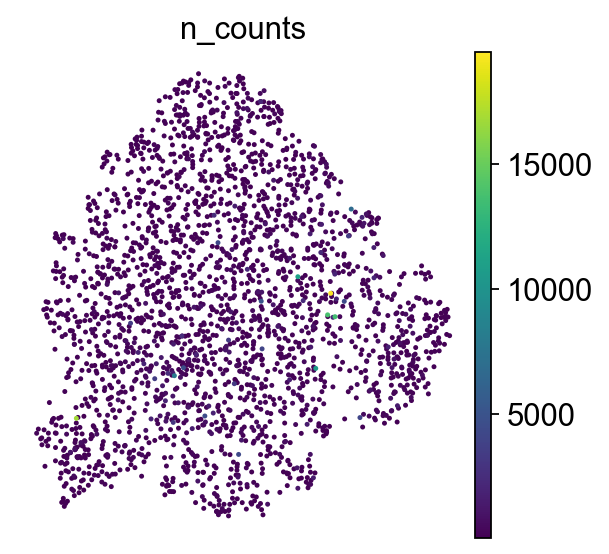

In [46]:
sc.pl.umap(adata, color='n_counts', size=20, save='_counts_per_cell.png')

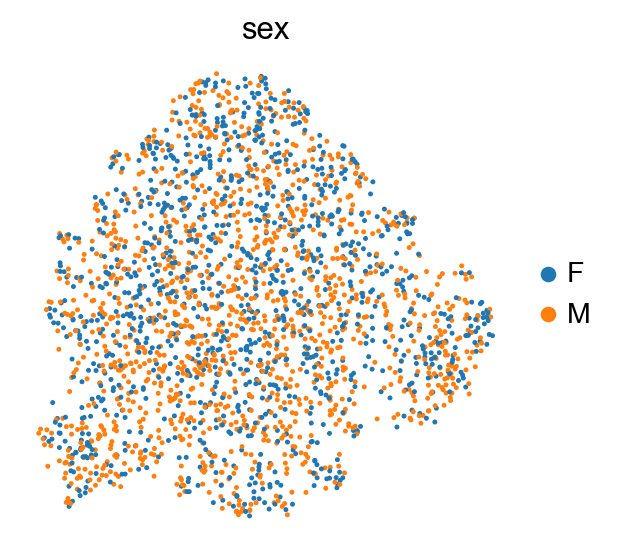

In [47]:
sc.pl.umap(adata, color='sex', size=20, save='_sex.png')

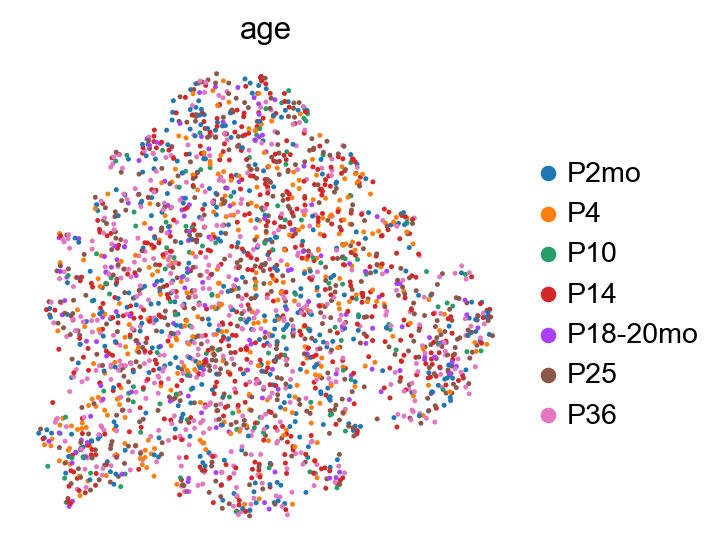

In [48]:
sc.pl.umap(adata, color='age', size=20, save='_age.png')

In [14]:
# marker_genes = ["Wnt4", "Cyp11a1", "Nr5a1", "Runx2", "Kdr", \
#                 "Flt1", "Csf1r", "F13a1", "Chga", "Nrg3", "Pnmt", \
#                 "Sox10", "Erbb3", "Ppargc1a", "Pparg", "Slc1a3", \
#                 "Ebf2", "Igf1", "C7", "Col1a1", "Wt1", "Ttn", "Myh4", \
#                 "Hnf4a", "Alb", "Sox6", "Hbb-bs", "mt-Nd2", "mt-Co1", "mt-Cytb"]
# for gene in marker_genes:
#     if gene in adata.var.annot_gene_name.tolist():
#         sc.pl.umap(adata, color=gene, gene_symbols='annot_gene_name', size=120, save='_{}.png'.format(gene))

In [16]:
adata.write('transcript_processed.h5ad')


In [25]:
adata = sc.read('transcript_processed.h5ad')
sc.settings.set_figure_params(frameon=False)
sc.settings.figdir = 'figures'

Does anything that popped out as isoform switching in the bulk look remotely interesting in the sc?

Srrm2


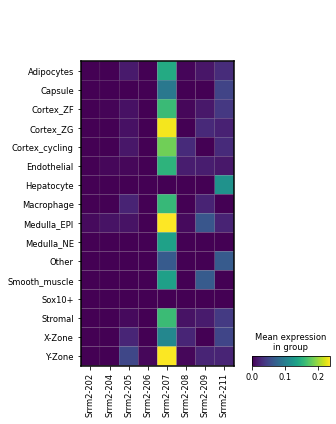

Igf1
Clu


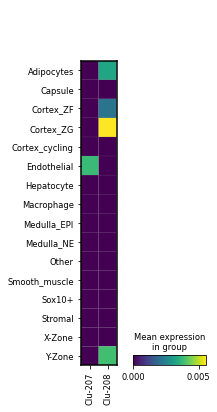

Irf3


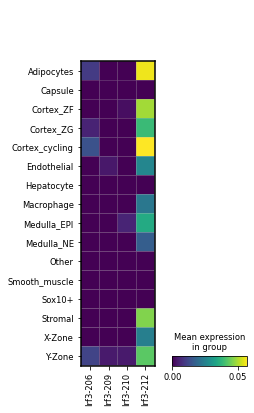

Cebpg


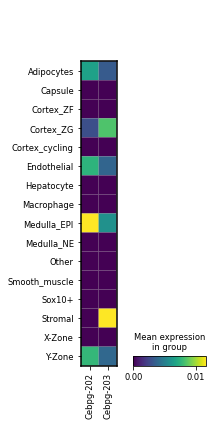

Cdk8


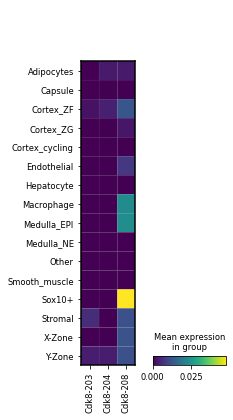

Ghr


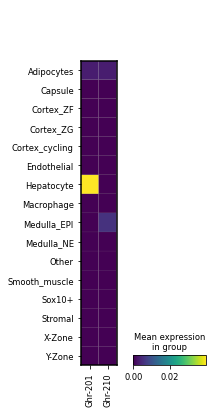

E2f6
Ets2


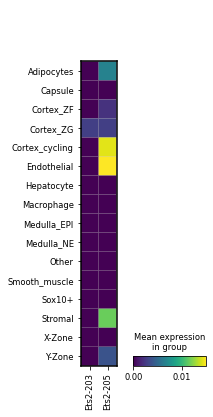

Nr1h2


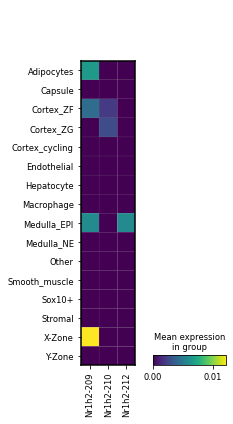

Pparg
Robo1


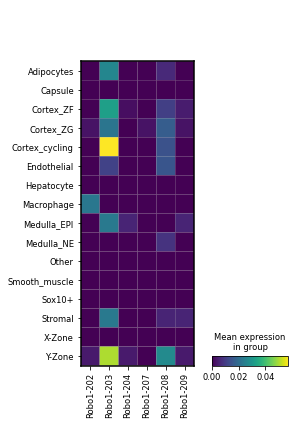

Rxrb


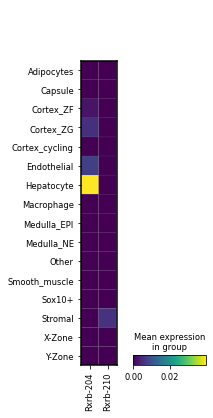

Stat1


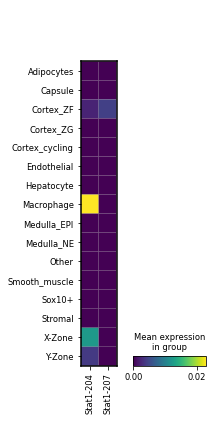

Tcf4


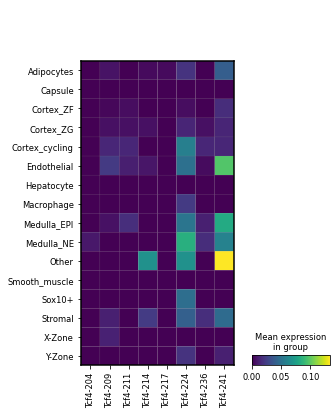

Gsn


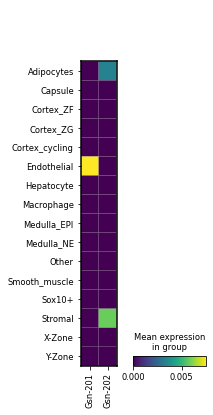

App


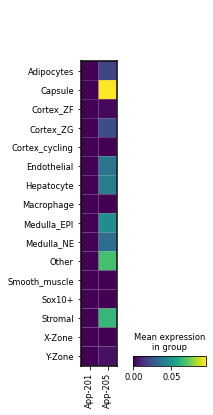

In [4]:
genes = ['Srrm2', 'Igf1', 'Clu', 'Irf3', 'Cebpg', 
         'Cdk8', 'Ghr', 'E2f6', 'Ets2', 
         'Nr1h2', 'Nr1h4', 'Nr5a1', 'Pparg', 
         'Robo1', 'Rxrb', 'Stat1', 'Tcf4',
         'Gsn', 'App']
for gene in genes:
    if gene in adata.var.annot_gene_name.tolist():
        print(gene)
        isos = adata.var.loc[adata.var.annot_gene_name == gene].index.tolist()
        if len(isos) != 1:
            sc.pl.matrixplot(adata,
                  var_names=isos,
                  groupby='lr_celltype')

Igf1
Clu


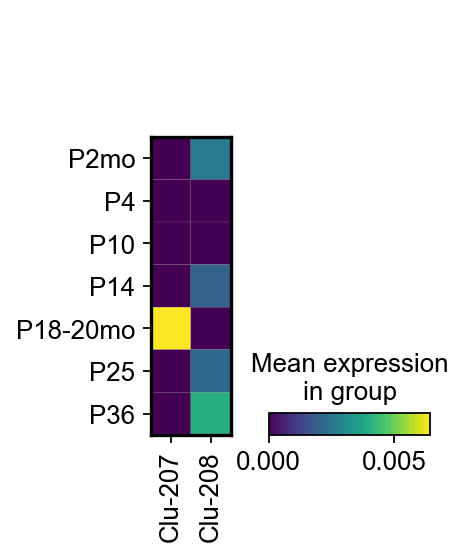

Irf3


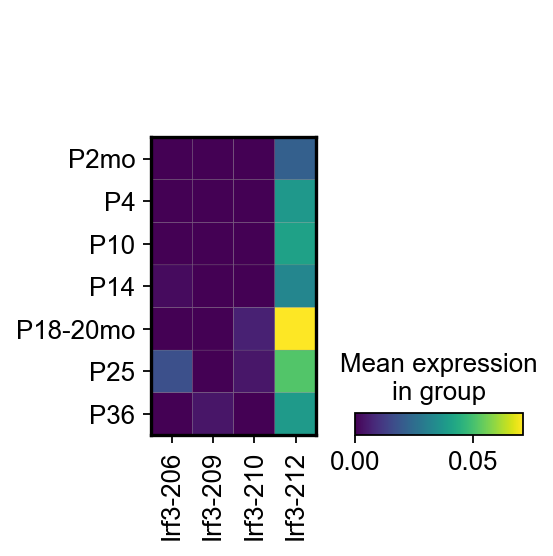

Cebpg


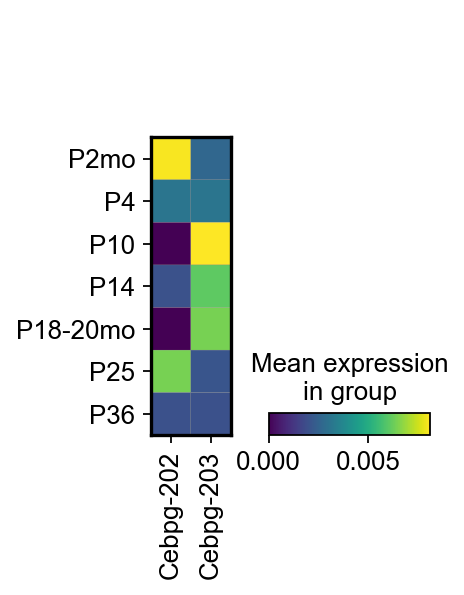

Cdk8


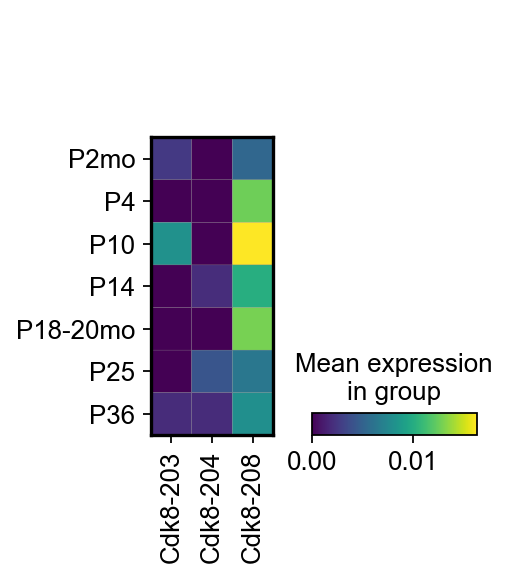

Ghr


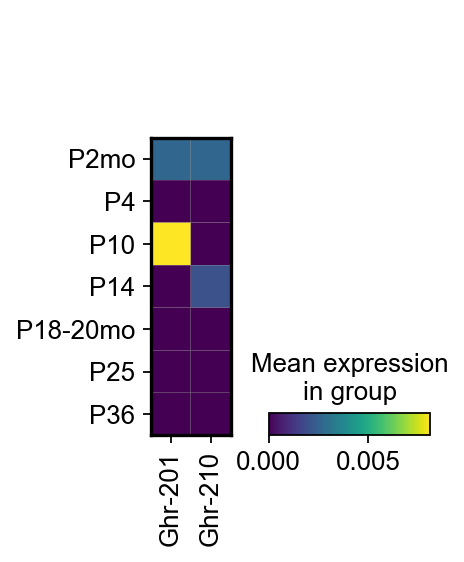

E2f6
Ets2


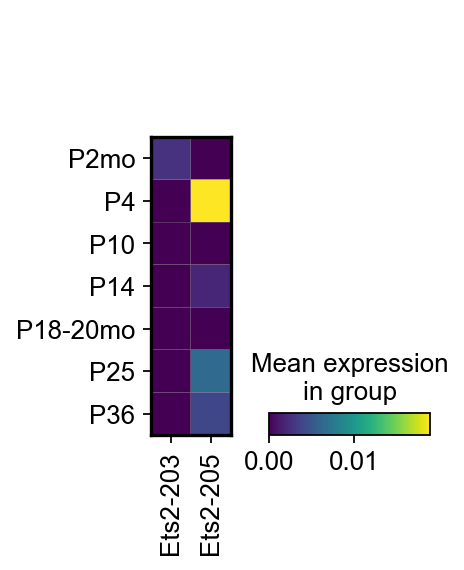

Nr1h2


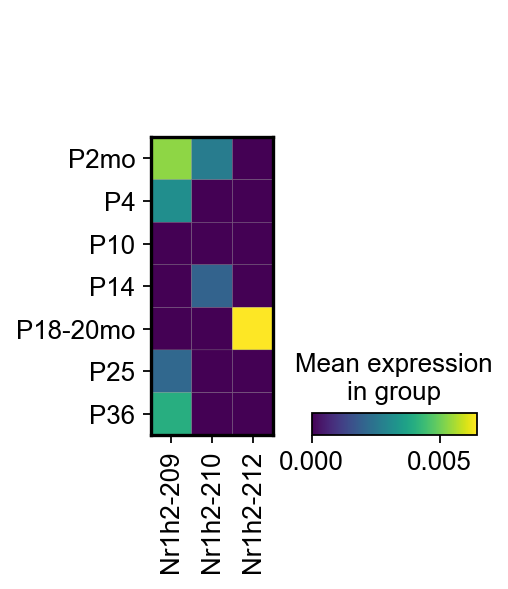

Pparg
Robo1


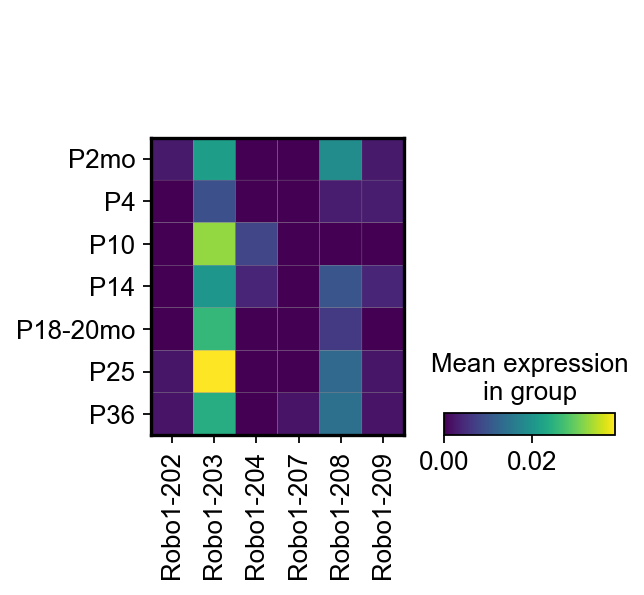

Rxrb


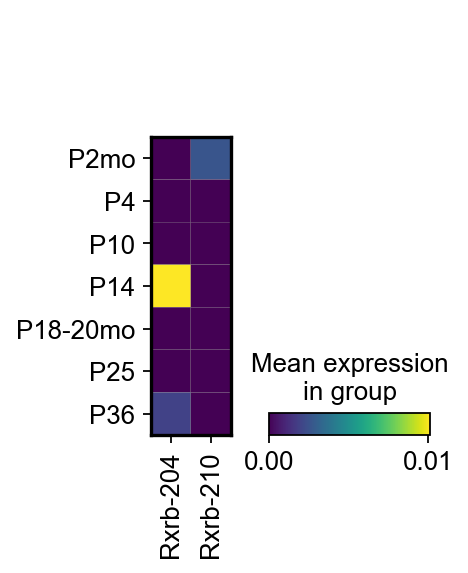

Stat1


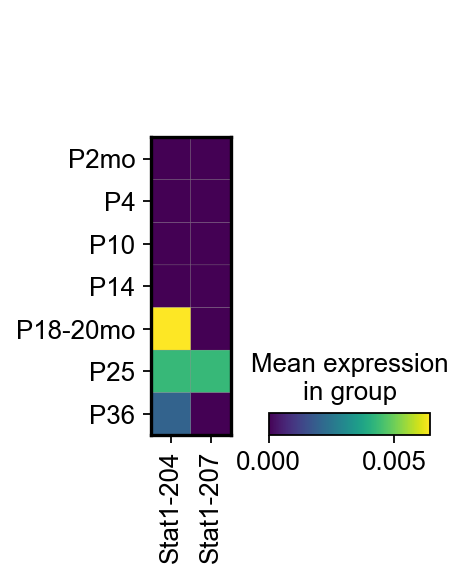

Tcf4


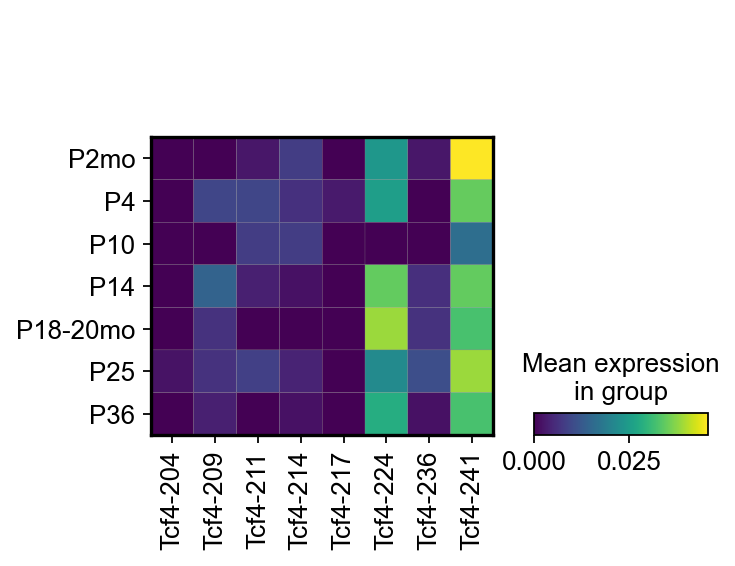

Gsn


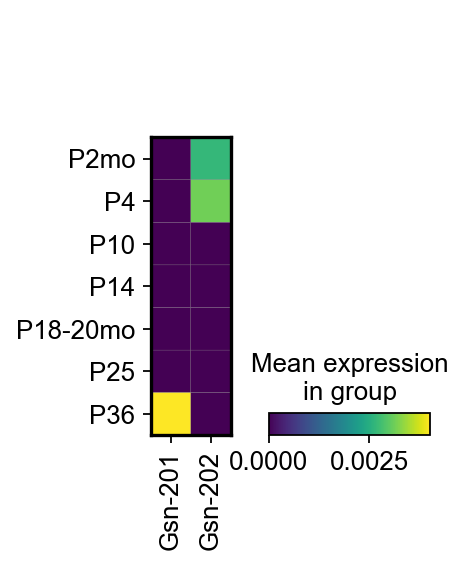

App


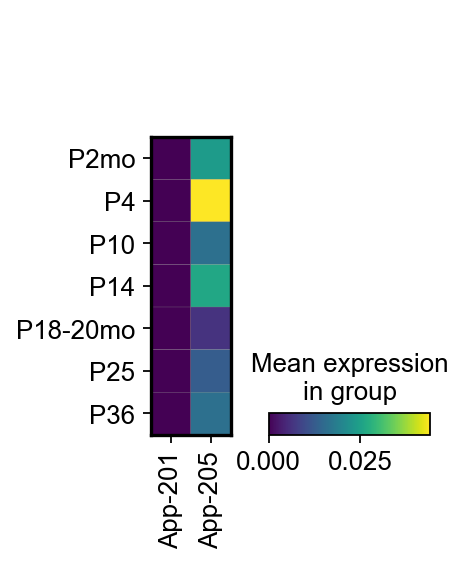

In [46]:
genes = ['Igf1', 'Clu', 'Irf3', 'Cebpg', 
         'Cdk8', 'Ghr', 'E2f6', 'Ets2', 
         'Nr1h2', 'Nr1h4', 'Nr5a1', 'Pparg', 
         'Robo1', 'Rxrb', 'Stat1', 'Tcf4', 
         'Gsn', 'App']
for gene in genes:
    if gene in adata.var.annot_gene_name.tolist():
        print(gene)
        isos = adata.var.loc[adata.var.annot_gene_name == gene].index.tolist()
        if len(isos) != 1:
            sc.pl.matrixplot(adata,
                  var_names=isos,
                  groupby='age')

In [41]:
adata.obs.age

bc_index
AAACATCGAACCGAGACTGTCCCG-ont_b      P14
AAACATCGAAGACGGAAGCGAAAC-ont_b     P2mo
AAACATCGAAGGACACCTGTCCCG-pb_2ka     P14
AAACATCGAATCCGTCAGCGAAAC-ont_b     P2mo
AAACATCGACGTATCAGTTACGTA-ont_b     P2mo
                                   ... 
TTCACGCATCCGTCTATTATTCTG-ont_b      P36
TTCACGCATGGAACAACGCGACTA-ont_b      P25
TTCACGCATGGAACAATACTCGAA-ont_b      P25
TTCACGCATGGCTTCAGACCTTTC-ont_b      P14
TTCACGCATGGTGGTAGAGCACAA-ont_b      P36
Name: age, Length: 2418, dtype: category
Categories (7, object): ['P2mo', 'P4', 'P10', 'P14', 'P18-20mo', 'P25', 'P36']

Which detected transcript has the most exons?

In [1]:
import scanpy as sc
import pandas as pd
import anndata
import os
import sys

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
filt_bcs = '../talon/adrenal_filt_bcs.txt'
df = pd.read_csv('../talon/adrenal_talon_read_annot.tsv', sep='\t')
df = get_transcript_exp(df,
                  nov=['Known', 'NIC', 'NNC'],
                  filt_sc_novel=True,
                  filt_bcs=filt_bcs)

In [3]:
df = df[['annot_transcript_id', 'annot_gene_name']]
df.head()

,annot_transcript_id,annot_gene_name
0,ENCODEMT000142671,Crem
1,ENCODEMT000144512,Pex2
2,ENCODEMT000145637,Ndufs8
3,ENCODEMT000147256,Penk
4,ENCODEMT000151946,Dynlt1b


In [4]:
# merge annot to get number of exons
annot = pd.read_csv('../talon/adrenal_talon_read_annot.tsv', sep='\t')

In [5]:
annot = annot[['annot_transcript_id', 'n_exons']]

In [6]:
annot.head()

,annot_transcript_id,n_exons
0,lr_splitseqT000153420,1
1,lr_splitseqT000153421,1
2,lr_splitseqT000153422,2
3,lr_splitseqT000153423,4
4,lr_splitseqT000153424,3


In [7]:
df = df.merge(annot, how='left', on='annot_transcript_id')

In [8]:
print(len(df.index))
df.head()

983237


,annot_transcript_id,annot_gene_name,n_exons
0,ENCODEMT000142671,Crem,3
1,ENCODEMT000144512,Pex2,4
2,ENCODEMT000145637,Ndufs8,6
3,ENCODEMT000147256,Penk,3
4,ENCODEMT000147256,Penk,3


In [9]:
df.sort_values(by='n_exons', ascending=False, inplace=True)

In [10]:
df

,annot_transcript_id,annot_gene_name,n_exons
791346,ENSMUST00000188868.6,Phip,25
282130,ENSMUST00000103114.7,Stat3,24
292678,ENSMUST00000125064.7,Med24,24
285400,ENSMUST00000113607.9,Copg1,24
922,ENCODEMT000586439,Stat3,24
...,...,...,...
364169,ENSMUST00000172812.2,Malat1,1
364170,ENSMUST00000172812.2,Malat1,1
364171,ENSMUST00000172812.2,Malat1,1
364172,ENSMUST00000172812.2,Malat1,1
